In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
all_airlines = pd.read_csv('BaggageComplaints.csv')

all_airlines.head()

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581


In [8]:
all_airlines.shape

(252, 8)

In [4]:
american = all_airlines[all_airlines['Airline']=='American Eagle'].copy()

american.head()

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
0,American Eagle,01/2004,1,2004,12502,38276,2481,992360
1,American Eagle,02/2004,2,2004,8977,35762,886,1060618
2,American Eagle,03/2004,3,2004,10289,39445,1346,1227469
3,American Eagle,04/2004,4,2004,8095,38982,755,1234451
4,American Eagle,05/2004,5,2004,10618,40422,2206,1267581


In [5]:
united = all_airlines[all_airlines['Airline']=='United'].copy()

united.head()

,Airline,Date,Month,Year,Baggage,Scheduled,Cancelled,Enplaned
168,United,01/2004,1,2004,25015,45809,1017,4434315
169,United,02/2004,2,2004,16660,42675,312,4458657
170,United,03/2004,3,2004,19318,46512,321,5302929
171,United,04/2004,4,2004,15638,45309,162,5288871
172,United,05/2004,5,2004,19302,46630,652,5408451


In [ ]:
# Load Data

data_path = '/content/drive/MyDrive/Colab Notebooks/6025 - Predictive Analytics/Forecasting Project/BaggageComplaints.csv'

bag_dat = pd.read_csv(data_path)

bag_dat.head
bag_dat.info()
print(bag_dat)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Airline    252 non-null    object
 1   Date       252 non-null    object
 2   Month      252 non-null    int64 
 3   Year       252 non-null    int64 
 4   Baggage    252 non-null    int64 
 5   Scheduled  252 non-null    int64 
 6   Cancelled  252 non-null    int64 
 7   Enplaned   252 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 15.9+ KB
            Airline     Date  Month  Year  Baggage  Scheduled  Cancelled  \
0    American Eagle  01/2004      1  2004    12502      38276       2481   
1    American Eagle  02/2004      2  2004     8977      35762        886   
2    American Eagle  03/2004      3  2004    10289      39445       1346   
3    American Eagle  04/2004      4  2004     8095      38982        755   
4    American Eagle  05/2004      5  2004    10618      40422       2206   

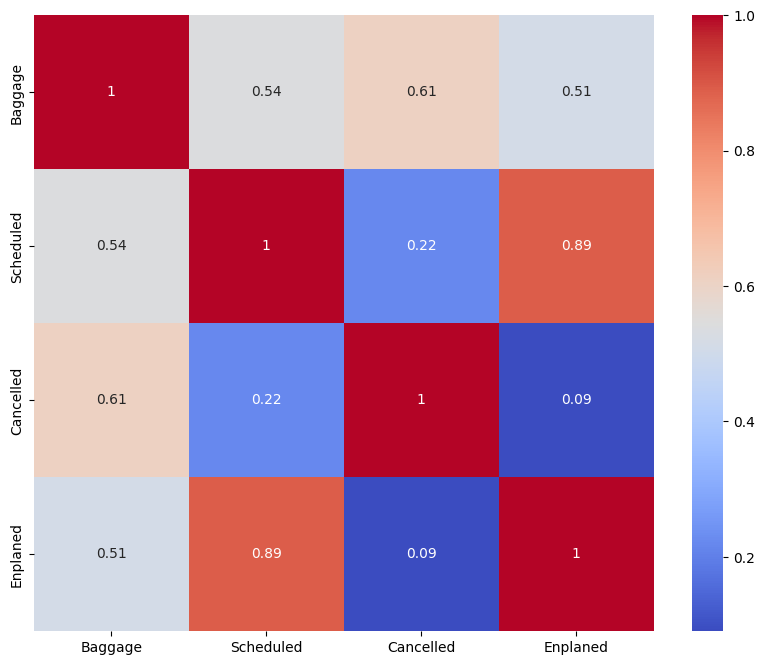

In [ ]:
bag_dat_sub = bag_dat.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = bag_dat_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

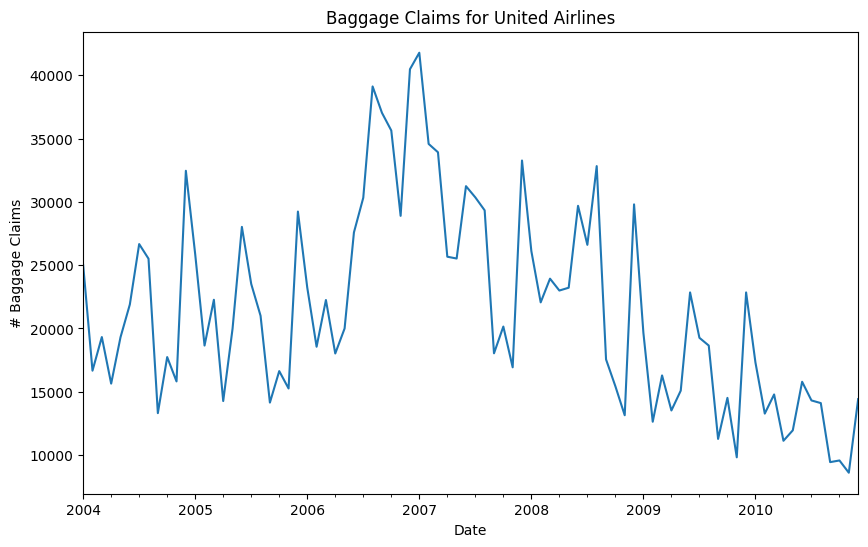

In [5]:
# Convert date column to a date class variable

# Create a monthly index for the series
united['Date'] = pd.to_datetime(united['Date'], format="%m/%Y")
bag_ts = pd.Series(united['Baggage'].values, index=united['Date'])

bag_ts.index.freq = 'MS'


#Plot the series
plt.figure(figsize=(10, 6))
bag_ts.plot()
plt.title("Baggage Claims for United Airlines")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.show()

In [7]:
#execute the Ljung Box test  using 10 lags
Bags = united[['Baggage']]

sm.stats.acorr_ljungbox(Bags, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,160.317171,2.786746e-29


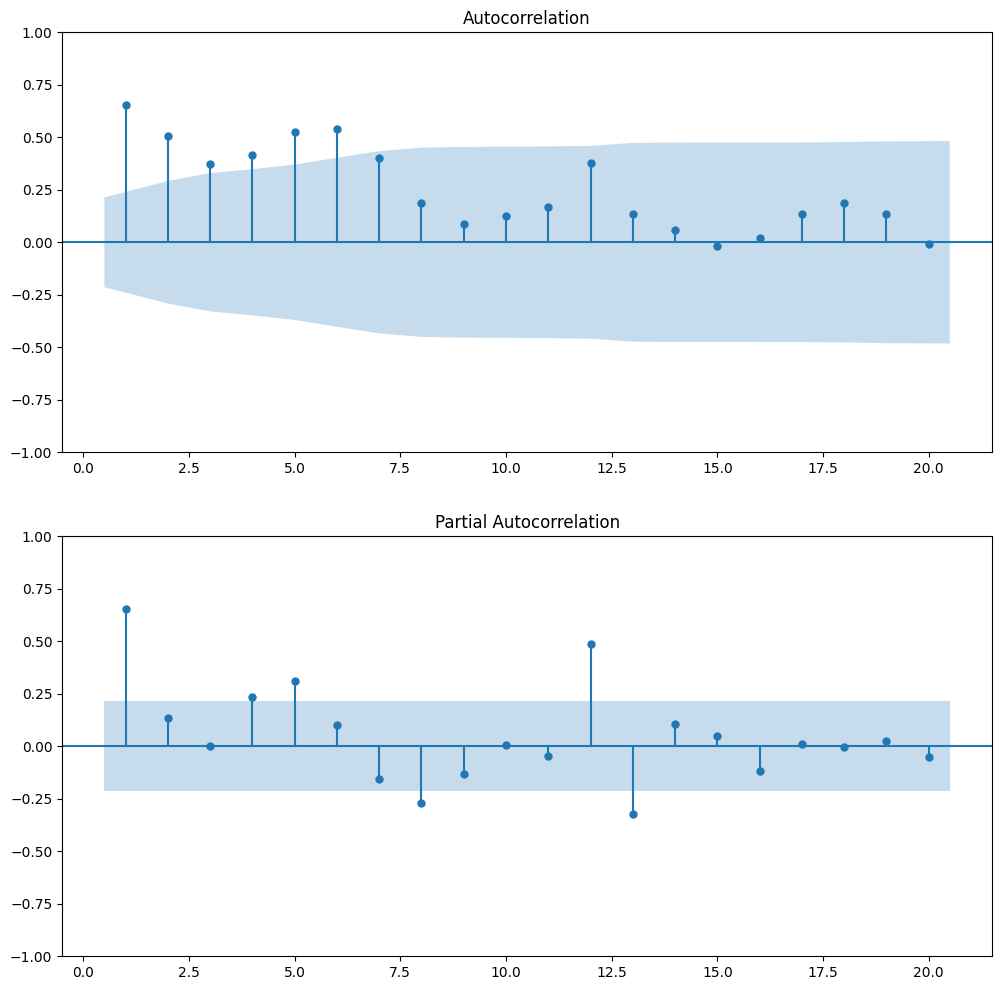

In [8]:
#Plot the ACF and PACF

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(bag_ts, ax=ax1, zero=False)
plot_pacf(bag_ts, ax=ax2, zero=False)
plt.show()

For seasonal time series, the first step in the process is taking a seasonal difference.  To do this, you need to include the seasonal_order(P,D,Q,s) option when you run the ARIMA procedure.  P is the number of seasonal AR terms, Q is the number of seasonal MA terms, s is the length of the seasonal period (for example, s=12 if it takes 12 months to complete the seasonal cycle).  To take a seasonal difference set D=1.

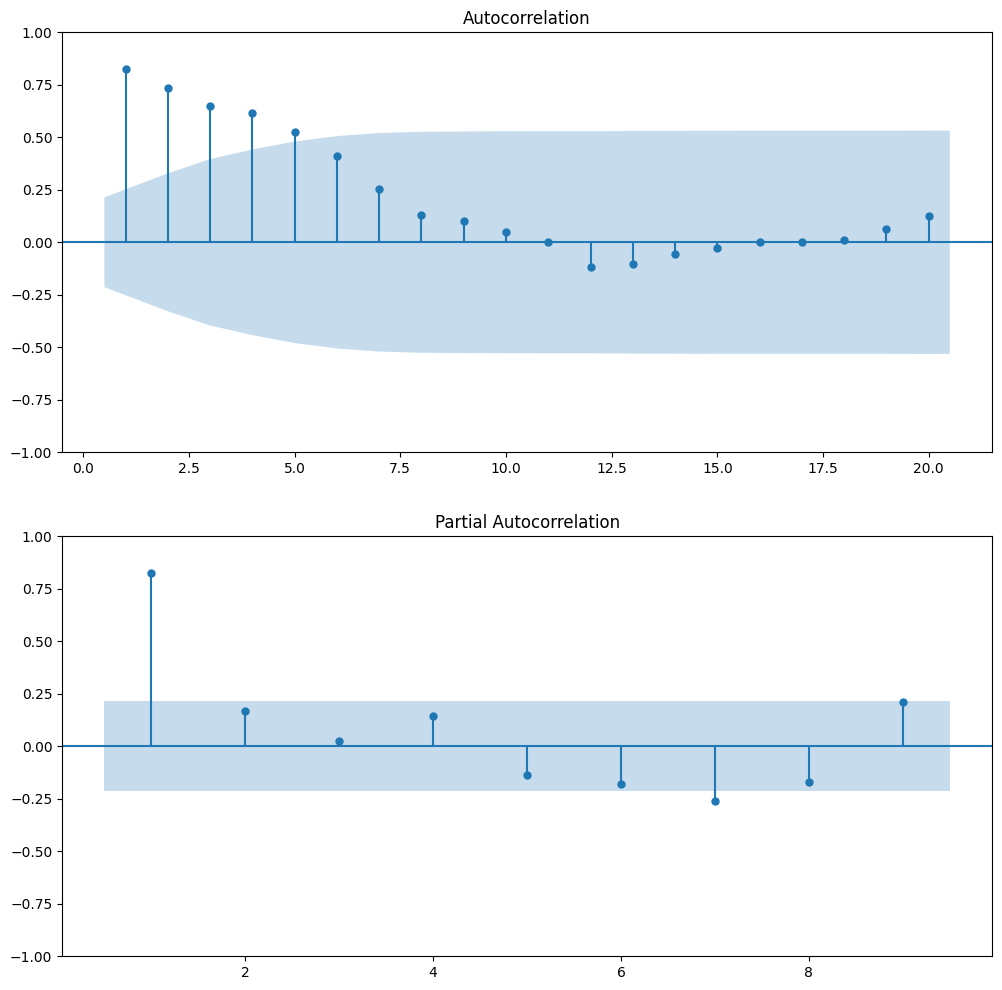

In [9]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(bag_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()


Notice that the ACF and PACF for the residuals look like a typical autoregressive signature, so the next step might be to add p = 1 to include an AR(1) term in the model.  This will not be sufficient to get the residuals to white noise.  Recall that an MA term can help to smooth out a model after differencing.  In this case we took a seasonal difference, so we'll include a seasonal MA term by setting Q=1 in the seasonal order.

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -706.585
Date:                            Sun, 22 Oct 2023   AIC                           1419.170
Time:                                    18:25:13   BIC                           1426.000
Sample:                                01-01-2004   HQIC                          1421.890
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8258      0.035     23.635      0.000       0.757       0.894
ma.S.L12      -0.6496      0.116   

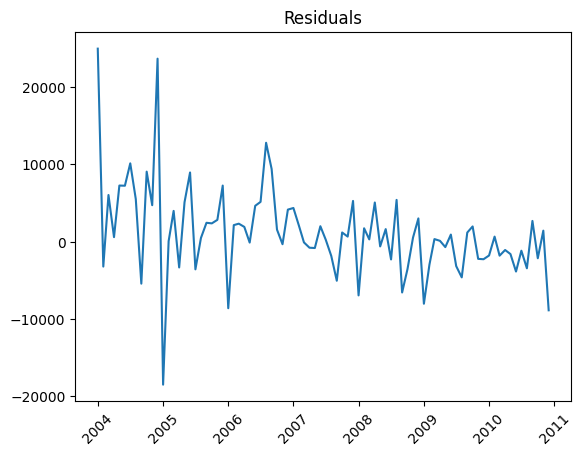

In [10]:
# Fit ARIMA(1,0,0)x(0,1,1)[12] model to the data

#Best model for Baggage Complaints for United is ARIMA(1,0,0)x(0,1,1)[12]
fit_AR1 = ARIMA(bag_ts, order=(1,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)


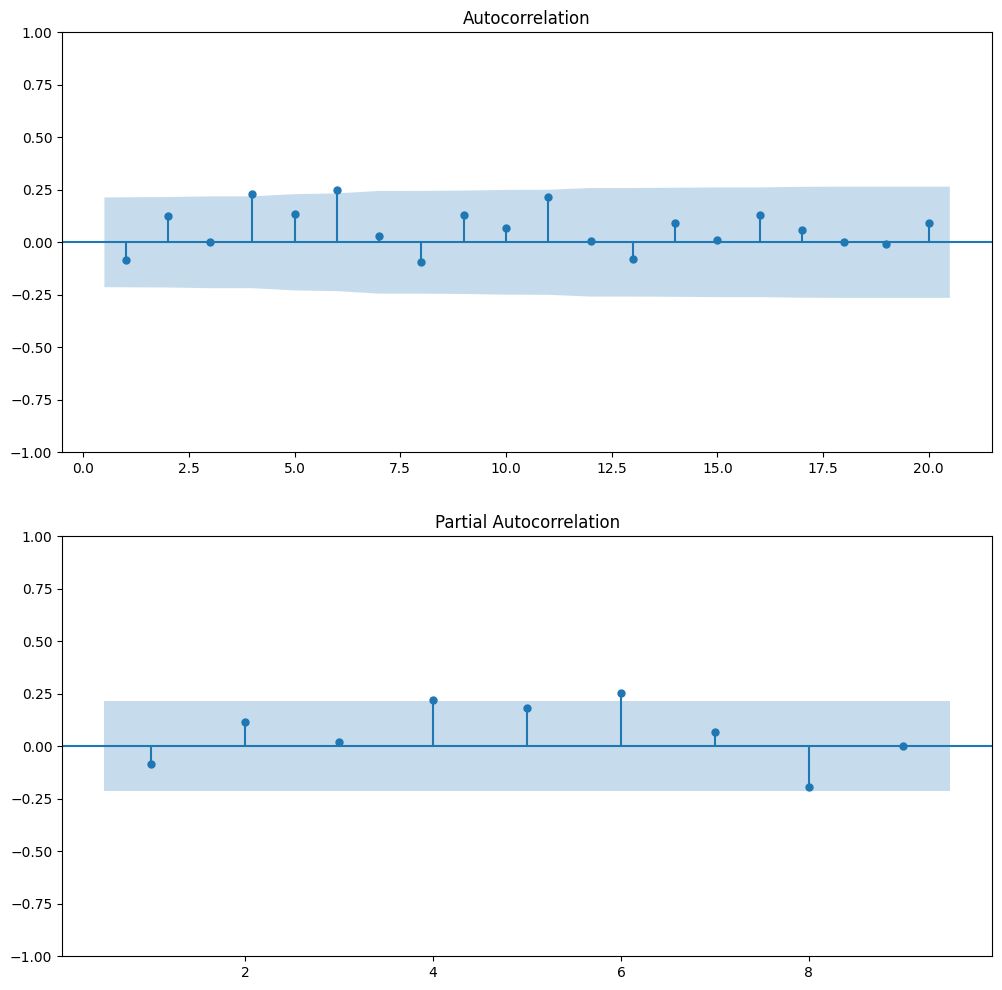

In [11]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()


After reviewing the ACF and PACF for the resiuals from this model and noticing that the Ljung Box test (below) indicates that the residuals are white noise, this seems to be a reasonable model for the data.

In [12]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,16.951913,0.075435


Convert predictions into a data frame in order to compute the forecast error

In [13]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df = prediction_df.tail(-1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,19898.744014,9639.203017,30158.285011
2004-03-01,13278.758482,3019.242911,23538.274052
2004-04-01,15061.243589,4805.267095,25317.220083
2004-05-01,12035.958696,1785.483779,22286.433612
2004-06-01,14649.272687,4406.927829,24891.617545


Join actual values to predicted values

In [14]:
# add back actuals --
prediction_df = pd.concat([prediction_df,bag_ts.to_frame(name='Baggage')],axis=1)
prediction_df = prediction_df.tail(-1)
prediction_df.head()




,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,19898.744014,9639.203017,30158.285011,16660
2004-03-01,13278.758482,3019.242911,23538.274052,19318
2004-04-01,15061.243589,4805.267095,25317.220083,15638
2004-05-01,12035.958696,1785.483779,22286.433612,19302
2004-06-01,14649.272687,4406.927829,24891.617545,21892


Calculate the Forecast Error

In [15]:
# calc error
errors = prediction_df['Baggage'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['Baggage'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 17.942%
RMSE = 5,462.825


Generate the forecast for the next six months

In [16]:
# Generate forecast for the next six months
forecast = fit_AR1.get_forecast(steps=6)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_Baggage': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_Baggage,Lower_Bound,Upper_Bound
2011-01-01,11517.989987,3166.755574,19869.224401
2011-02-01,8070.936387,-2757.702057,18899.574831
2011-03-01,11672.924016,-560.511295,23906.359327
2011-04-01,9262.037189,-3843.209135,22367.283512
2011-05-01,11463.779642,-2204.058916,25131.618201
2011-06-01,17903.990424,3865.490787,31942.490060


Plot the series and append the six month forecast.  Notice that the forecast follows a pattern similar to the one observed in the actual data

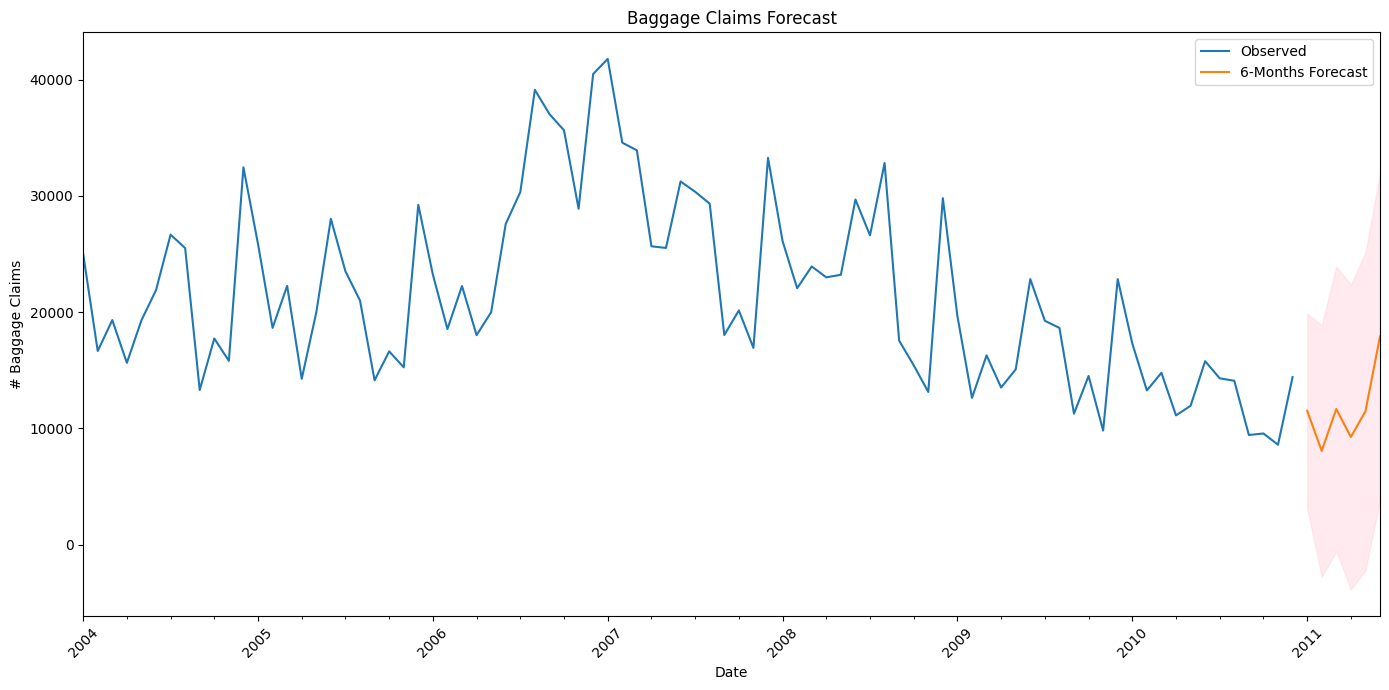

In [ ]:

# Plot forecast
plt.figure(figsize=(14, 7))
bag_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Baggage Claims Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## United Cancelled Flights

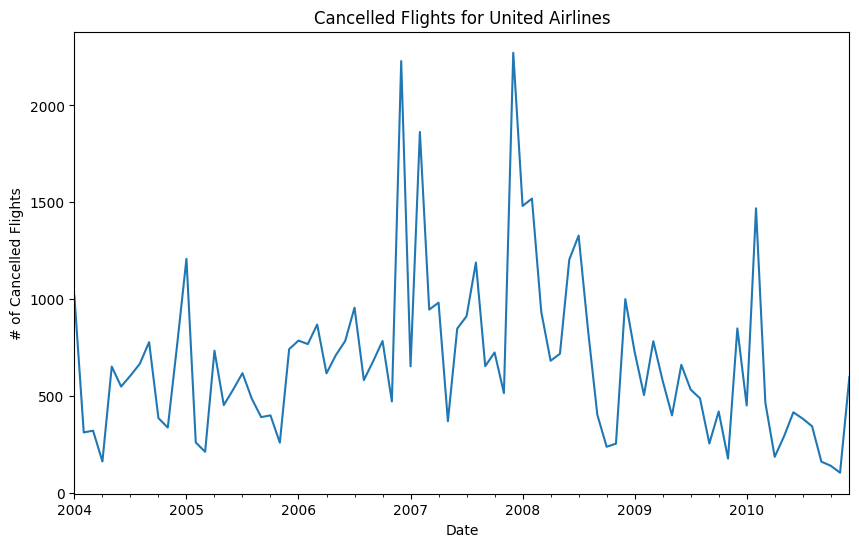

In [35]:
# Convert date column to a date class variable

# Create a monthly index for the series
united['Date'] = pd.to_datetime(united['Date'], format="%m/%Y")
united_cancel_ts = pd.Series(united['Cancelled'].values, index=united['Date'])

united_cancel_ts.index.freq = 'MS'

# plot
plt.figure(figsize=(10, 6))
united_cancel_ts.plot()
plt.title("Cancelled Flights for United Airlines")
plt.xlabel("Date")
plt.ylabel("# of Cancelled Flights")
plt.show()

### Ljung Box Test

In [11]:
#execute the Ljung Box test on the United Cancelled series using 10 lags
uni_can = united[['Cancelled']]

sm.stats.acorr_ljungbox(uni_can, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,37.135304,0.000054


### Plot initial ACF and PACF

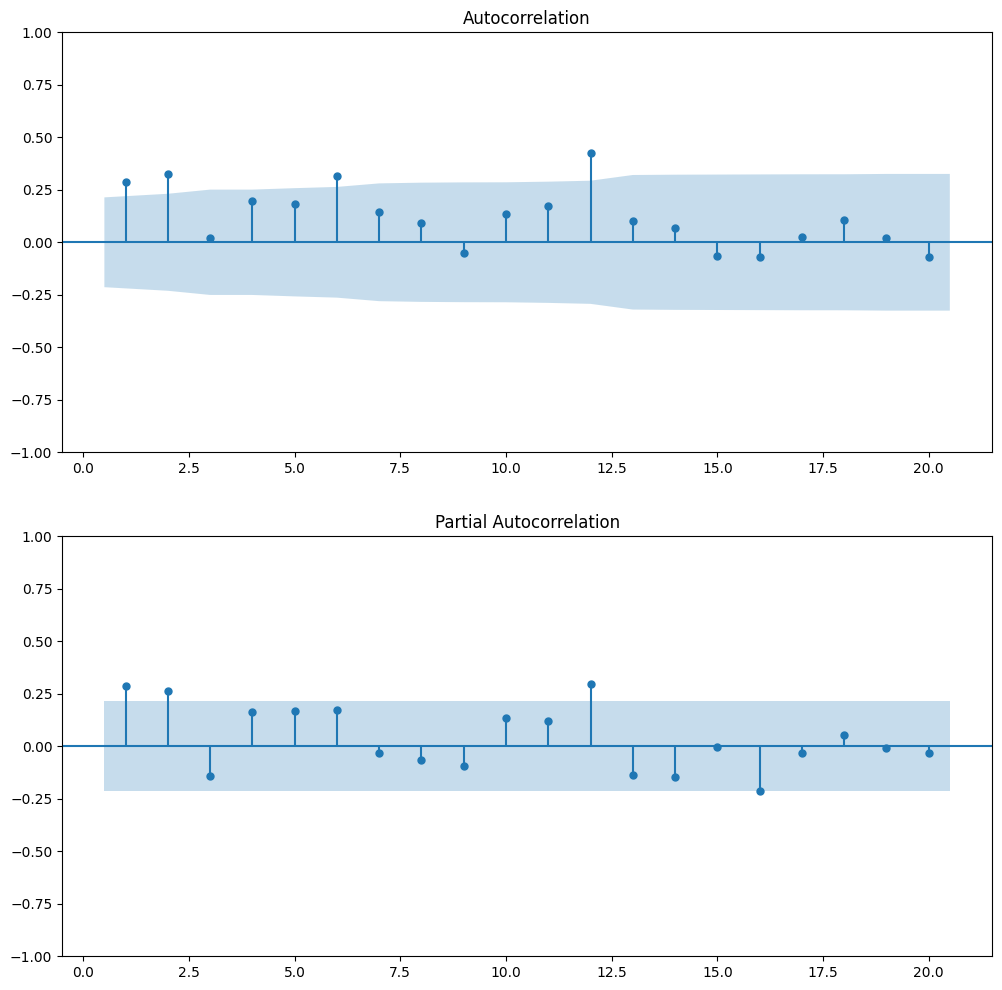

In [46]:
#Plot the ACF and PACF for the United Cancelled series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(united_cancel_ts, ax=ax1, zero=False)
plot_pacf(united_cancel_ts, ax=ax2, zero=False)
plt.show()

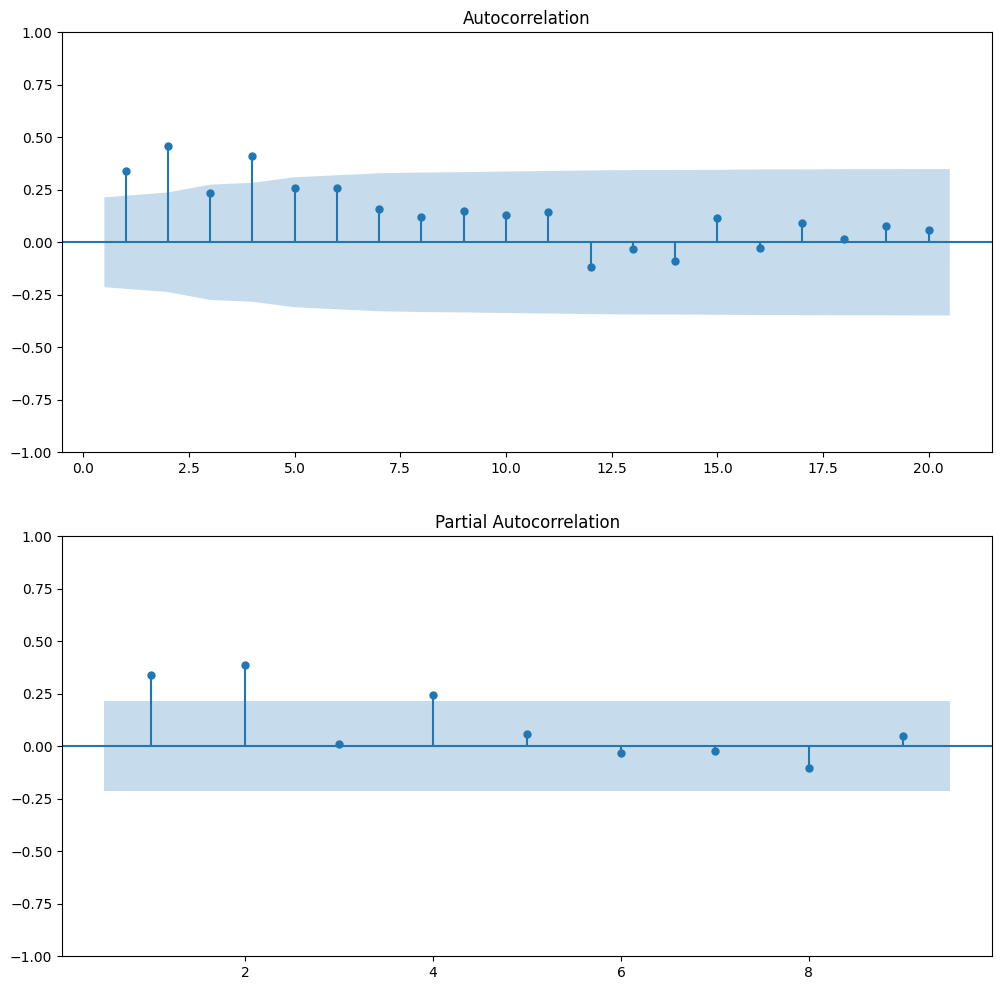

In [13]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(united_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=9)
plt.show()


## ARIMA(2,0,0)x(0,1,1)[12] ended up being the best model

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -528.251
Date:                            Sat, 21 Oct 2023   AIC                           1064.501
Time:                                    19:05:39   BIC                           1073.608
Sample:                                01-01-2004   HQIC                          1068.127
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2038      0.091      2.246      0.025       0.026       0.382
ar.L2          0.4335      0.086   

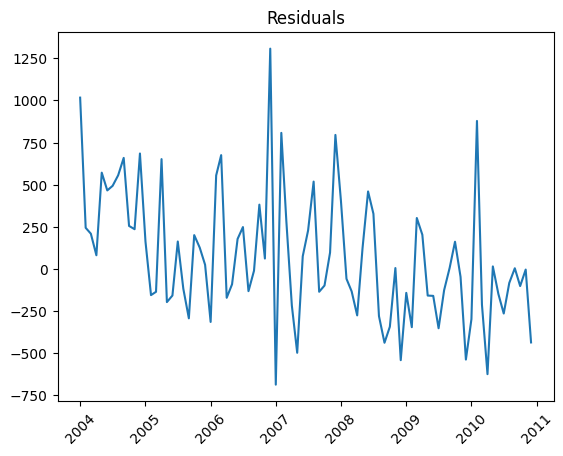

In [90]:
# Fit ARIMA(2,0,0)x(0,1,1)[12] model to the data

fit_AR2 = ARIMA(united_cancel_ts, order=(2,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR2.summary())

# Examine residuals from the model
residuals2 = fit_AR2.resid
plt.plot(residuals2)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units2 = fit_AR2.get_prediction()
print(pred_units2)

In [91]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,14.645233,0.145541


In [92]:
# convert to data frame
predicted_mean2 = pred_units2.predicted_mean
conf_int2 = pred_units2.conf_int()

prediction_df2 = pd.DataFrame({
    'predicted_mean': predicted_mean2,
    'lower_bound': conf_int2.iloc[:, 0],
    'upper_bound': conf_int2.iloc[:, 1]
})
prediction_df2 = prediction_df2.tail(-1)
prediction_df2.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,67.689413,-2111.295560,2246.674386
2004-03-01,111.617093,-2058.288275,2281.522460
2004-04-01,80.478285,-2088.197694,2249.154264
2004-05-01,80.234820,-2087.262471,2247.732112
2004-06-01,82.668750,-2084.667914,2250.005414


In [93]:
# add back actuals --
prediction_df2 = pd.concat([prediction_df2,united_cancel_ts.to_frame(name='Cancelled')],axis=1)
prediction_df2 = prediction_df2.tail(-1)
prediction_df2.head()

,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,67.689413,-2111.295560,2246.674386,312
2004-03-01,111.617093,-2058.288275,2281.522460,321
2004-04-01,80.478285,-2088.197694,2249.154264,162
2004-05-01,80.234820,-2087.262471,2247.732112,652
2004-06-01,82.668750,-2084.667914,2250.005414,549


In [95]:
# calc error
errors2 = prediction_df2['Cancelled'] - prediction_df2['predicted_mean']
# absolue value of error
errors_abs2 = errors2.abs()
# -- mape --
mape2 = (errors_abs2/prediction_df2['Cancelled'].abs()).mean()
# -- rmse
rmse2 = (errors2**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape2:.3%}')
print(f'RMSE = {rmse2:,.3f}')


MAPE = 48.698%
RMSE = 380.126


In [98]:
# Generate forecast for the next six months
forecast2 = fit_AR2.get_forecast(steps=6)
mean_forecast2 = forecast2.predicted_mean
confidence_intervals2 = forecast2.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df2 = pd.DataFrame({
    'Forecasted_Cancelled': mean_forecast2,
    'Lower_Bound': confidence_intervals2.iloc[:, 0],
    'Upper_Bound': confidence_intervals2.iloc[:, 1]
})

forecast_df2

,Forecasted_Cancelled,Lower_Bound,Upper_Bound
2011-01-01,547.621831,-155.670057,1250.913719
2011-02-01,852.413769,134.680399,1570.147140
2011-03-01,509.236264,-282.371505,1300.844032
2011-04-01,303.110520,-499.121741,1105.342781
2011-05-01,325.908946,-494.398479,1146.216371
2011-06-01,562.942855,-262.429269,1388.314978


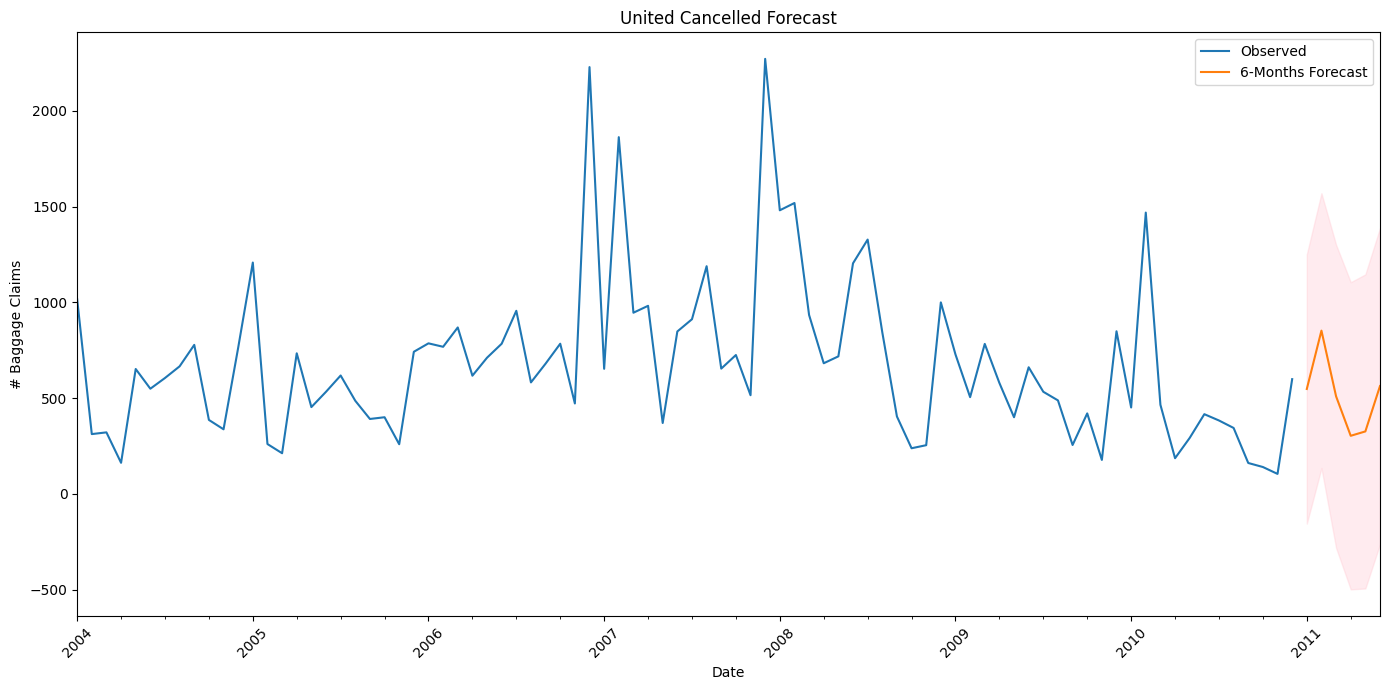

In [100]:

# Plot forecast
plt.figure(figsize=(14, 7))
united_cancel_ts.plot(label='Observed', legend=True)
mean_forecast2.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals2.index,
                 confidence_intervals2.iloc[:, 0],
                 confidence_intervals2.iloc[:, 1], color='pink', alpha=0.3)
plt.title("United Cancelled Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

# American Eagle

### Correlation Heat Map

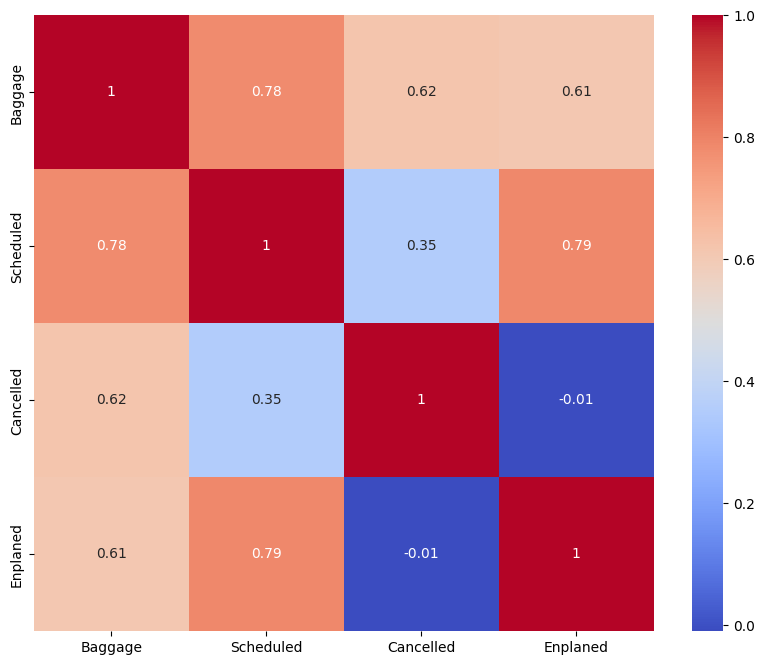

In [6]:
american_sub = american.drop(columns=['Airline', 'Date', 'Month', 'Year'])


# Compute correlations
cormat = american_sub.corr()

# Round correlation matrix to 2 decimal places
cormat = cormat.round(2)

# Plot correlation matrix using a heatmap
plt.figure(figsize = (10,8))
sns.heatmap(cormat,annot=True, cmap = 'coolwarm')
plt.show()

#### Above we can see that Cancelled, Scheduled, and Enplaned all have moderately strong, positive linear relationships with baggage complaints.

### American Cancelled ARIMA

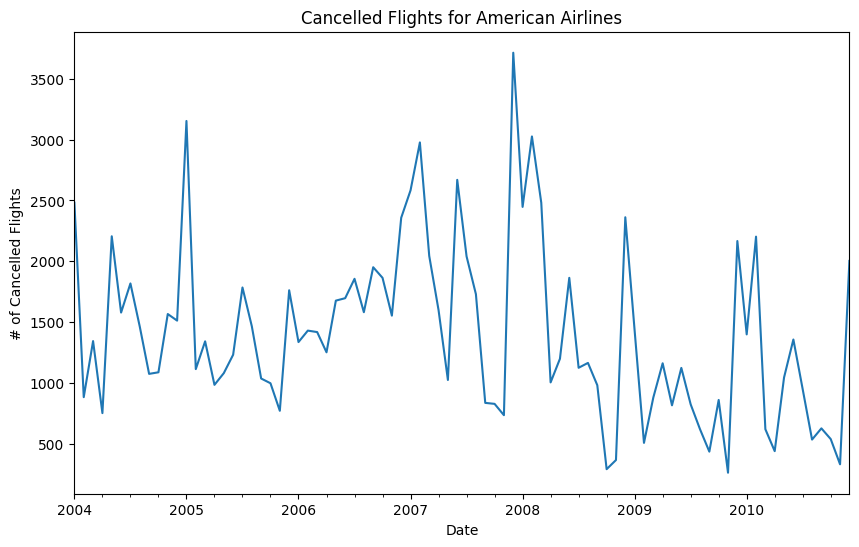

In [7]:
# Convert date column to a date class variable

# Create a monthly index for the series
american['Date'] = pd.to_datetime(american['Date'], format="%m/%Y")
american_cancel_ts = pd.Series(american['Cancelled'].values, index=american['Date'])

american_cancel_ts.index.freq = 'MS'

# plot
plt.figure(figsize=(10, 6))
american_cancel_ts.plot()
plt.title("Cancelled Flights for American Airlines")
plt.xlabel("Date")
plt.ylabel("# of Cancelled Flights")
plt.show()

### Ljung Box Test for white noise

In [8]:
#execute the Ljung Box test on the American Cancelled series using 10 lags
amer_can = american[['Cancelled']]

sm.stats.acorr_ljungbox(amer_can, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,33.222572,0.00025


### Initial ACF and PACF

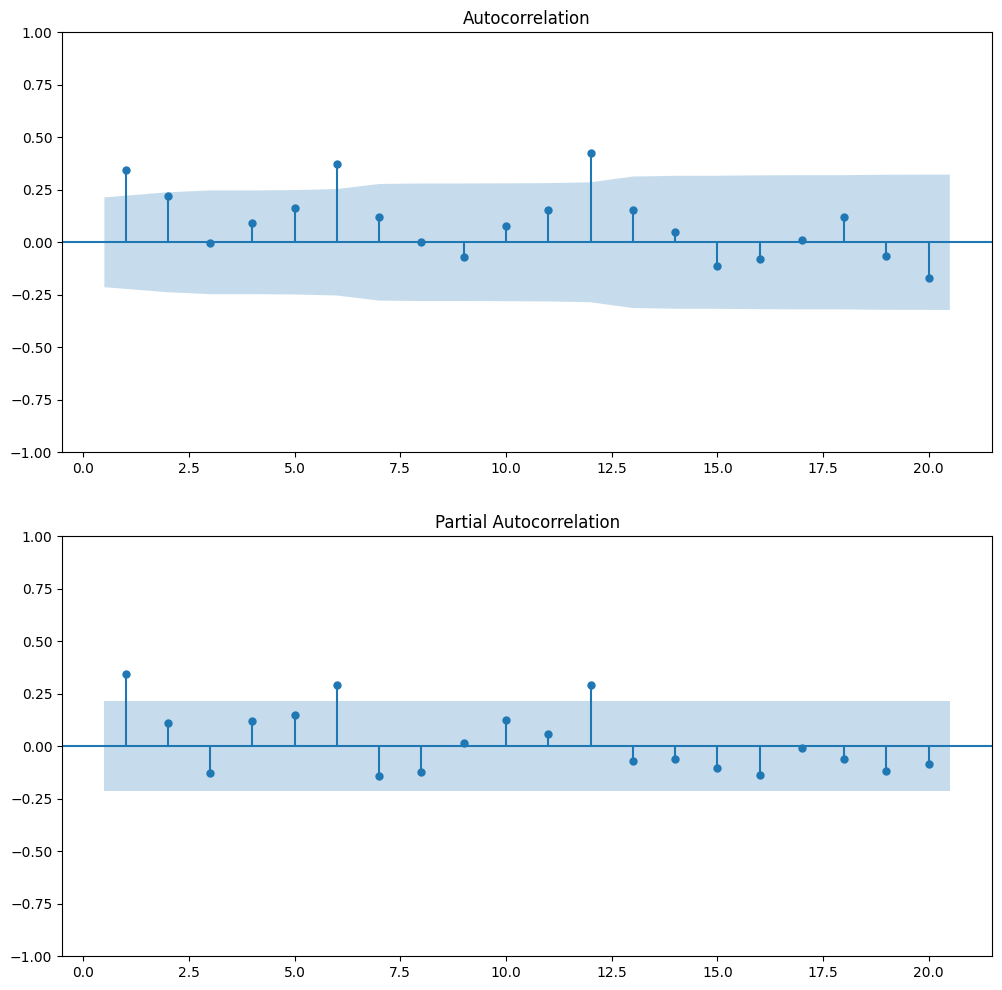

In [9]:
#Plot the ACF and PACF for the American Cancelled series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_cancel_ts, ax=ax1, zero=False)
plot_pacf(american_cancel_ts, ax=ax2, zero=False)
plt.show()

### Here we can see seasonality so we will take a 12-month seasonal difference

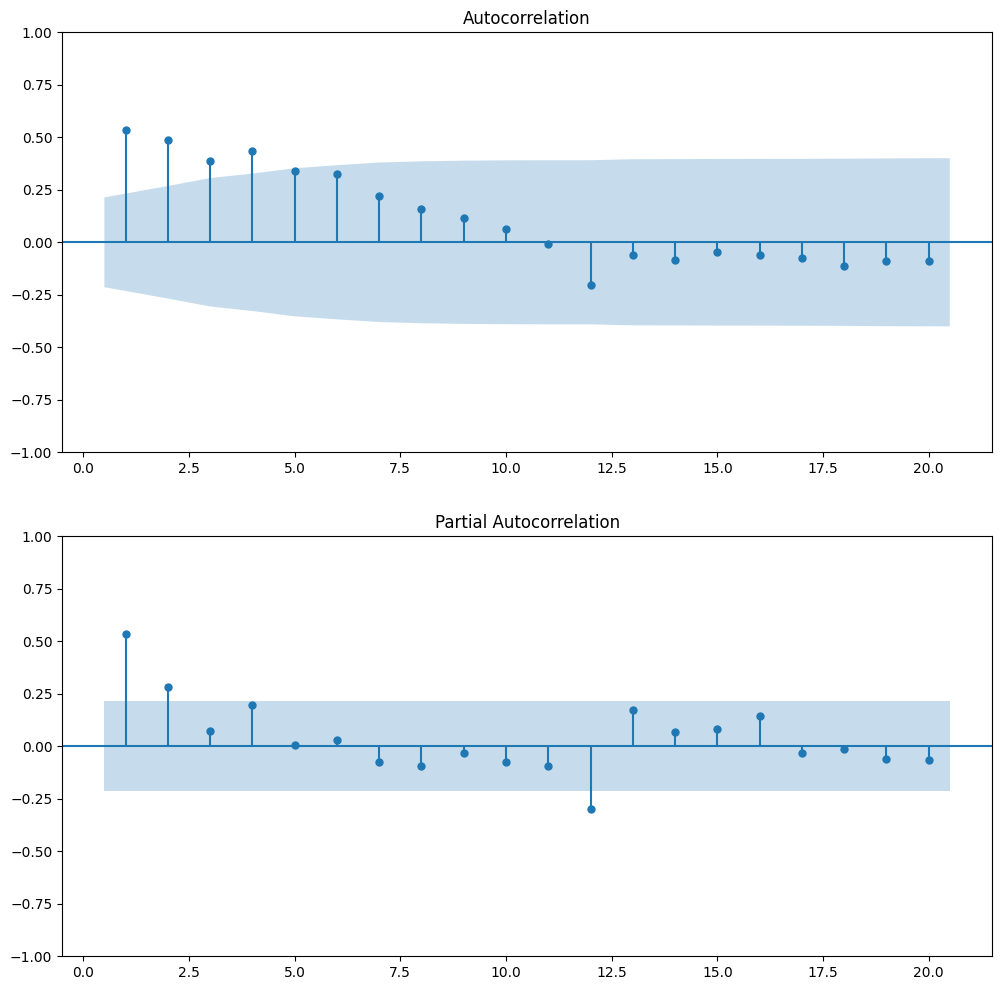

In [36]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD12 = ARIMA(american_cancel_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals12 = fit_ARD12.resid


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals12, ax=ax1, zero=False)
plot_pacf(residuals12, ax=ax2, zero=False, lags=20)
plt.show()


### After a few iterations, Ended up with an ARIMA(0,1,1)x(0,1,1)[12]

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                   84
Model:             ARIMA(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -555.732
Date:                          Mon, 23 Oct 2023   AIC                           1117.464
Time:                                  01:24:36   BIC                           1124.252
Sample:                              01-01-2004   HQIC                          1120.163
                                   - 12-01-2010                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7398      0.080     -9.236      0.000      -0.897      -0.583
ma.S.L12      -0.6459      0.131     -4.924      0.

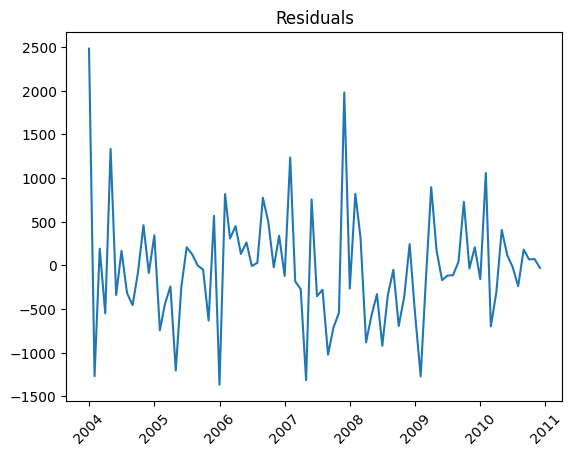

In [14]:

#Best model for American Cancelled for United is ARIMA(2,0,0)x(0,1,1)[12]
fit_AR1 = ARIMA(american_cancel_ts, order=(0,1,1), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR1.summary())

# Examine residuals from the model
residuals1 = fit_AR1.resid
plt.plot(residuals1)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units1 = fit_AR1.get_prediction()
print(pred_units1)


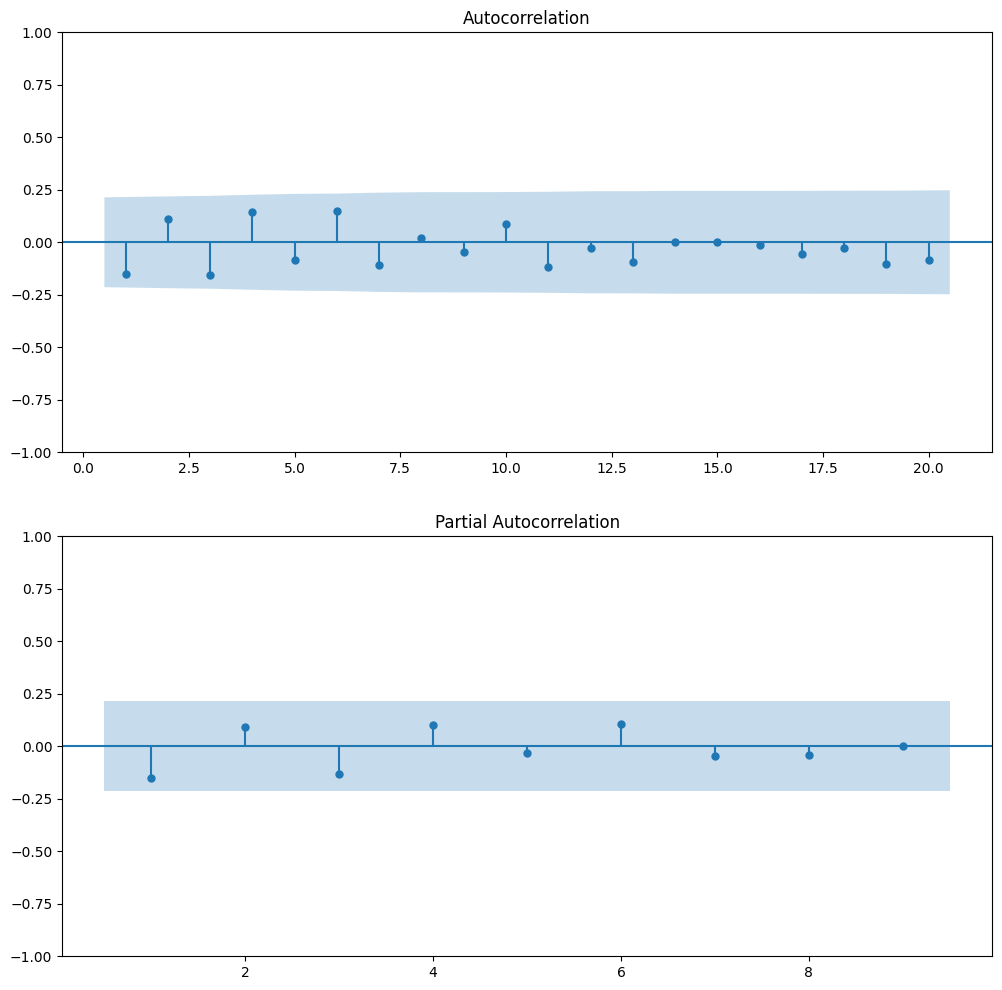

In [15]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals1, ax=ax1, zero=False)
plot_pacf(residuals1, ax=ax2, zero=False, lags=9)
plt.show()


In [16]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals1, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.054303,0.281439


### ACF, PACF, and White Noise look good

### Next test predicted values against actual to generate MAPE and RMSE

In [17]:
# convert to data frame
predicted_mean1 = pred_units1.predicted_mean
conf_int1 = pred_units1.conf_int()

prediction_df1 = pd.DataFrame({
    'predicted_mean': predicted_mean1,
    'lower_bound': conf_int1.iloc[:, 0],
    'upper_bound': conf_int1.iloc[:, 1]
})
prediction_df1 = prediction_df1.tail(-1)
prediction_df1.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,2156.130784,-404.690206,4716.951774
2004-03-01,1154.339966,-1384.658726,3693.338658
2004-04-01,1304.809035,-1233.194354,3842.812424
2004-05-01,873.255905,-1664.701466,3411.213276
2004-06-01,1919.335786,-618.619456,4457.291028


In [18]:
# add back actuals --
prediction_df1 = pd.concat([prediction_df1,american_cancel_ts.to_frame(name='Cancelled')],axis=1)
prediction_df1 = prediction_df1.tail(-1)
prediction_df1.head()


,predicted_mean,lower_bound,upper_bound,Cancelled
Date,,,,
2004-02-01,2156.130784,-404.690206,4716.951774,886
2004-03-01,1154.339966,-1384.658726,3693.338658,1346
2004-04-01,1304.809035,-1233.194354,3842.812424,755
2004-05-01,873.255905,-1664.701466,3411.213276,2206
2004-06-01,1919.335786,-618.619456,4457.291028,1580


In [19]:
# calc error
errors1 = prediction_df1['Cancelled'] - prediction_df1['predicted_mean']
# absolue value of error
errors_abs1 = errors1.abs()
# -- mape --
mape1 = (errors_abs1/prediction_df1['Cancelled'].abs()).mean()
# -- rmse
rmse1 = (errors1**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape1:.3%}')
print(f'RMSE = {rmse1:,.3f}')


MAPE = 40.851%
RMSE = 606.978


### Finally, generate 6-month forecast for 2011 and plot on graph

In [20]:
# Generate forecast for the next six months
forecast1 = fit_AR1.get_forecast(steps=6)
mean_forecast1 = forecast1.predicted_mean
confidence_intervals1 = forecast1.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df1 = pd.DataFrame({
    'Forecasted_Cancelled': mean_forecast1,
    'Lower_Bound': confidence_intervals1.iloc[:, 0],
    'Upper_Bound': confidence_intervals1.iloc[:, 1]
})

forecast_df1

,Forecasted_Cancelled,Lower_Bound,Upper_Bound
2011-01-01,1460.406857,309.808788,2611.004926
2011-02-01,1505.445602,316.510807,2694.380397
2011-03-01,879.431011,-346.615683,2105.477704
2011-04-01,564.038165,-698.024946,1826.101277
2011-05-01,760.709864,-536.369190,2057.788919
2011-06-01,1191.057524,-140.116586,2522.231633


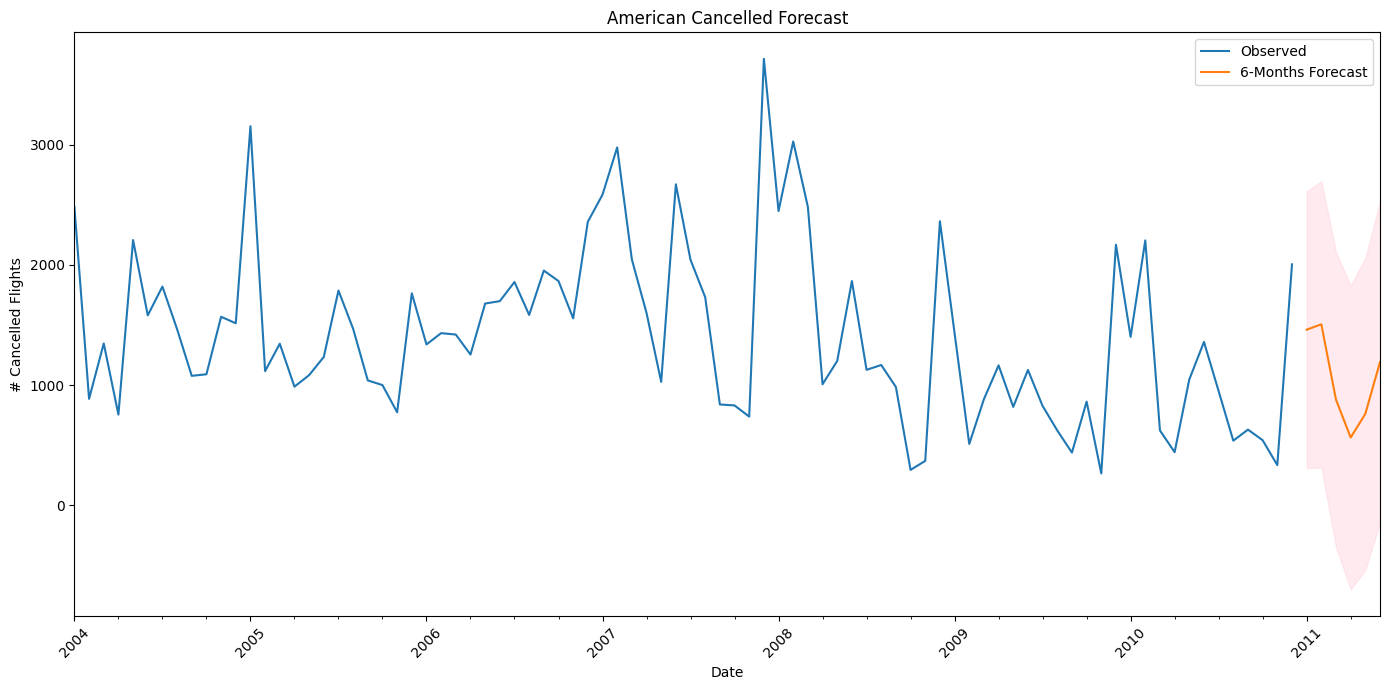

In [21]:

# Plot forecast
plt.figure(figsize=(14, 7))
american_cancel_ts.plot(label='Observed', legend=True)
mean_forecast1.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals1.index,
                 confidence_intervals1.iloc[:, 0],
                 confidence_intervals1.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Cancelled Forecast")
plt.xlabel("Date")
plt.ylabel("# Cancelled Flights")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

## American Baggage Complaints

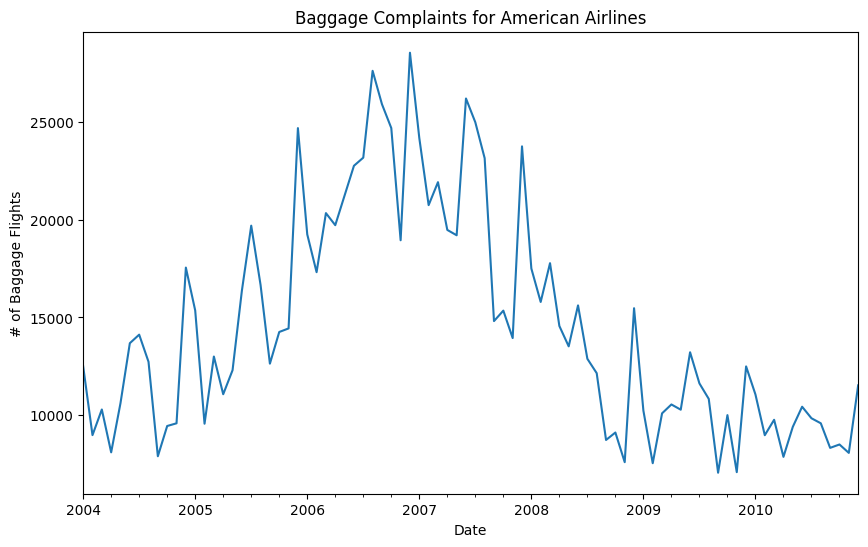

In [22]:
# Convert date column to a date class variable

# Create a monthly index for the series
american['Date'] = pd.to_datetime(american['Date'], format="%m/%Y")
american_baggage_ts = pd.Series(american['Baggage'].values, index=american['Date'])

american_baggage_ts.index.freq = 'MS'

# plot
plt.figure(figsize=(10, 6))
american_baggage_ts.plot()
plt.title("Baggage Complaints for American Airlines")
plt.xlabel("Date")
plt.ylabel("# of Baggage Flights")
plt.show()

### Initial Ljung Box Test

In [23]:
#execute the Ljung Box test on the American Cancelled series using 10 lags
amer_bag = american[['Baggage']]

sm.stats.acorr_ljungbox(amer_bag, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,363.970723,4.308185e-72


### Plot initial ACF and PACF

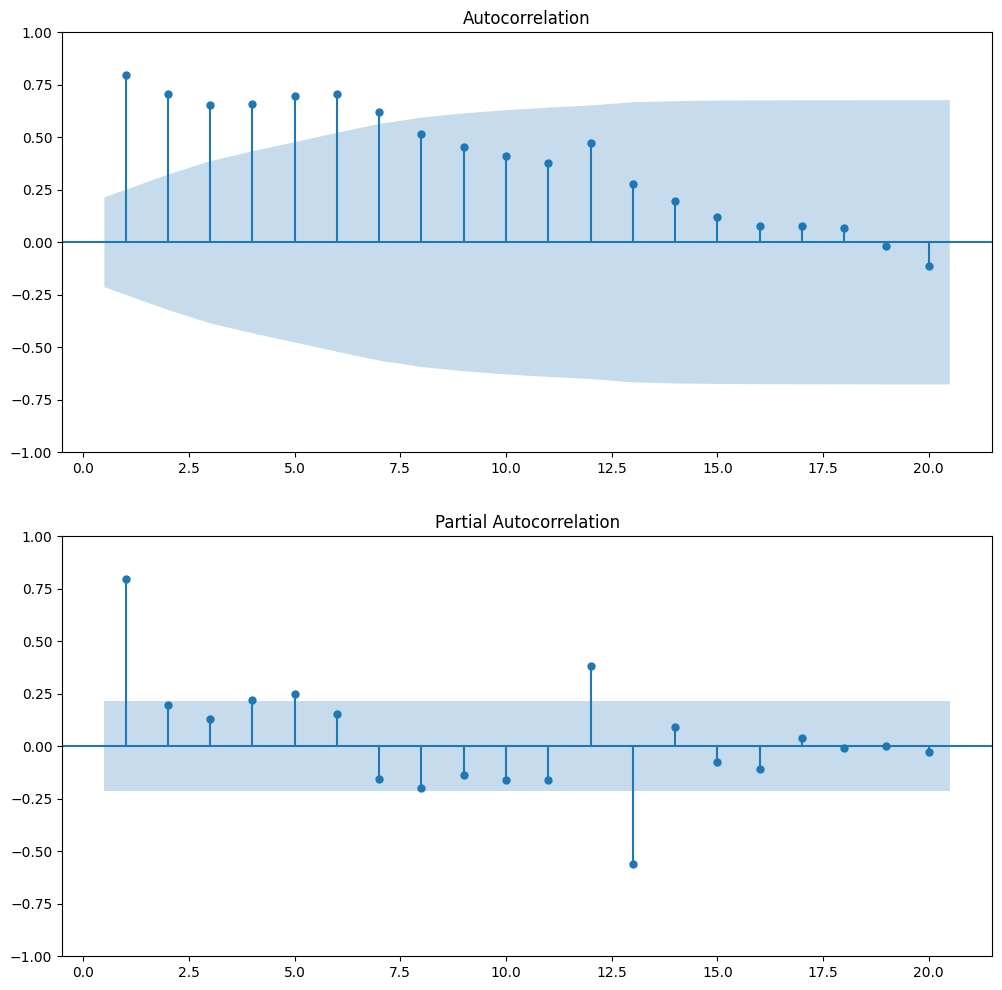

In [25]:
#Plot the ACF and PACF for the American Baggage series

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(american_baggage_ts, ax=ax1, zero=False)
plot_pacf(american_baggage_ts, ax=ax2, zero=False)
plt.show()

### Add Seasonal Difference

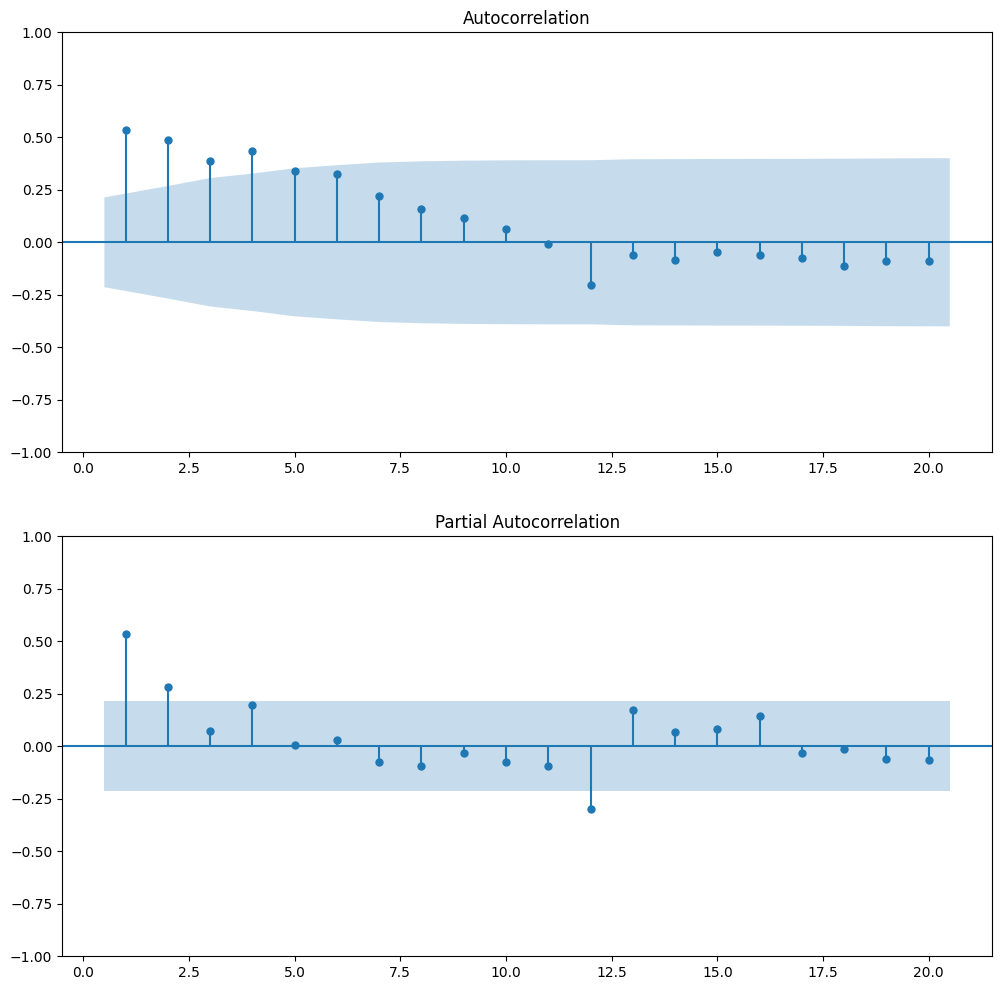

In [26]:
# Fit ARIMA(0,0,0)x(0,1,0)[12] model to the data - This is simply taking the 12-month seasonal difference
#  which is yt - y(t-12)

fit_ARD2 = ARIMA(american_baggage_ts, order=(0,0,0), seasonal_order=(0, 1, 0, 12)).fit()

# Plot ACF and PACF for residuals from the seasonal difference in order to
# assess the correlation still remaining in the data

residuals2 = fit_ARD12.resid

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals2, ax=ax1, zero=False)
plot_pacf(residuals2, ax=ax2, zero=False, lags=20)
plt.show()


### ARIMA(1,0,0)x(0,1,1)[12] ended up being the best model

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   84
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -669.273
Date:                            Mon, 23 Oct 2023   AIC                           1344.546
Time:                                    01:34:18   BIC                           1351.376
Sample:                                01-01-2004   HQIC                          1347.265
                                     - 12-01-2010                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9322      0.025     37.466      0.000       0.883       0.981
ma.S.L12      -0.8991      0.167   

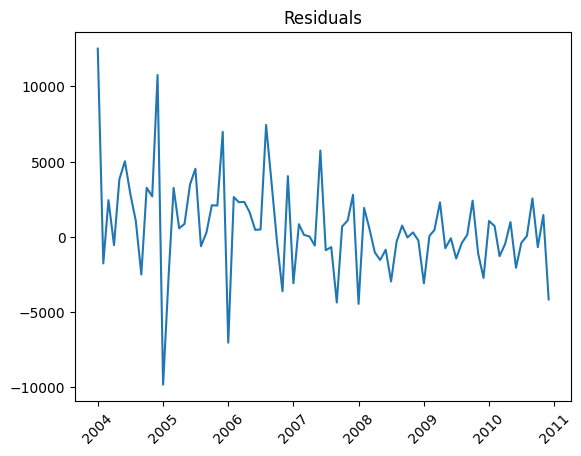

In [27]:

#Best model for Baggage Complaints for American is ARIMA(1,0,0)x(0,1,1)[12]
fit_AR2 = ARIMA(american_baggage_ts, order=(1,0,0), seasonal_order=(0, 1, 1, 12)).fit()


# Summary of the ARIMA model
print(fit_AR2.summary())

# Examine residuals from the model
residuals2 = fit_AR2.resid
plt.plot(residuals2)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units2 = fit_AR2.get_prediction()
print(pred_units1)


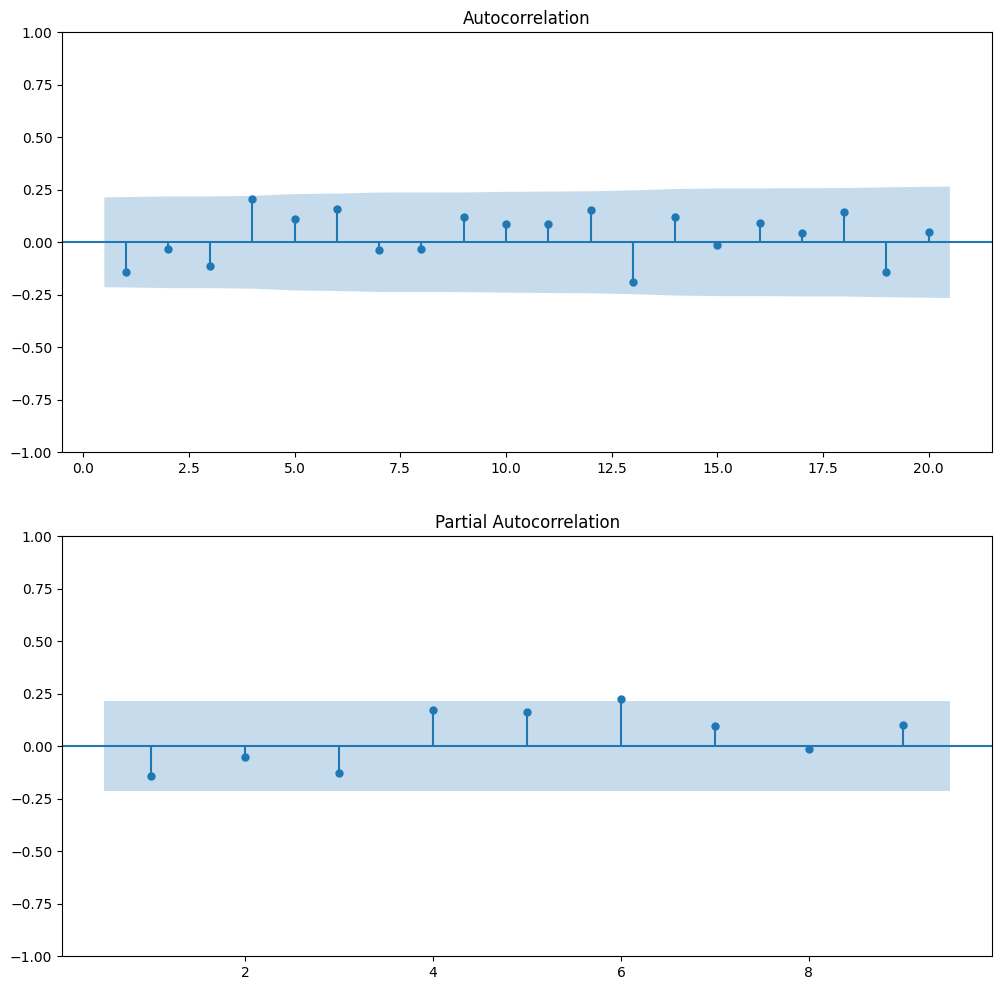

In [28]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals2, ax=ax1, zero=False)
plot_pacf(residuals2, ax=ax2, zero=False, lags=9)
plt.show()


In [29]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals2, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,12.58116,0.248041


In [30]:
# convert to data frame
predicted_mean2 = pred_units2.predicted_mean
conf_int2 = pred_units2.conf_int()

prediction_df2 = pd.DataFrame({
    'predicted_mean': predicted_mean2,
    'lower_bound': conf_int2.iloc[:, 0],
    'upper_bound': conf_int2.iloc[:, 1]
})
prediction_df2 = prediction_df2.tail(-1)
prediction_df2.head()

,predicted_mean,lower_bound,upper_bound
Date,,,
2004-02-01,10741.483989,4154.036008,17328.931970
2004-03-01,7851.631984,1266.949707,14436.314261
2004-04-01,8645.248626,2066.425134,15224.072118
2004-05-01,6801.570026,231.640277,13371.499775
2004-06-01,8661.787547,2102.656772,15220.918322


In [31]:
# add back actuals --
prediction_df2 = pd.concat([prediction_df2,american_baggage_ts.to_frame(name='Baggage')],axis=1)
prediction_df2 = prediction_df2.tail(-1)
prediction_df2.head()


,predicted_mean,lower_bound,upper_bound,Baggage
Date,,,,
2004-02-01,10741.483989,4154.036008,17328.931970,8977
2004-03-01,7851.631984,1266.949707,14436.314261,10289
2004-04-01,8645.248626,2066.425134,15224.072118,8095
2004-05-01,6801.570026,231.640277,13371.499775,10618
2004-06-01,8661.787547,2102.656772,15220.918322,13684


In [32]:
# calc error
errors2 = prediction_df2['Baggage'] - prediction_df2['predicted_mean']
# absolue value of error
errors_abs2 = errors2.abs()
# -- mape --
mape2 = (errors_abs2/prediction_df2['Baggage'].abs()).mean()
# -- rmse
rmse2 = (errors2**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape2:.3%}')
print(f'RMSE = {rmse2:,.3f}')


MAPE = 14.710%
RMSE = 3,004.210


In [33]:
# Generate forecast for the next six months
forecast2 = fit_AR2.get_forecast(steps=6)
mean_forecast2 = forecast2.predicted_mean
confidence_intervals2 = forecast2.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df2 = pd.DataFrame({
    'Forecasted_Baggage': mean_forecast2,
    'Lower_Bound': confidence_intervals2.iloc[:, 0],
    'Upper_Bound': confidence_intervals2.iloc[:, 1]
})

forecast_df2

,Forecasted_Baggage,Lower_Bound,Upper_Bound
2011-01-01,9288.021290,4638.843591,13937.198990
2011-02-01,6723.942662,388.345667,13059.539657
2011-03-01,8761.913629,1267.442311,16256.384947
2011-04-01,7338.662697,-1031.272614,15708.598007
2011-05-01,8084.122679,-975.966745,17144.212104
2011-06-01,10955.026874,1337.671683,20572.382064


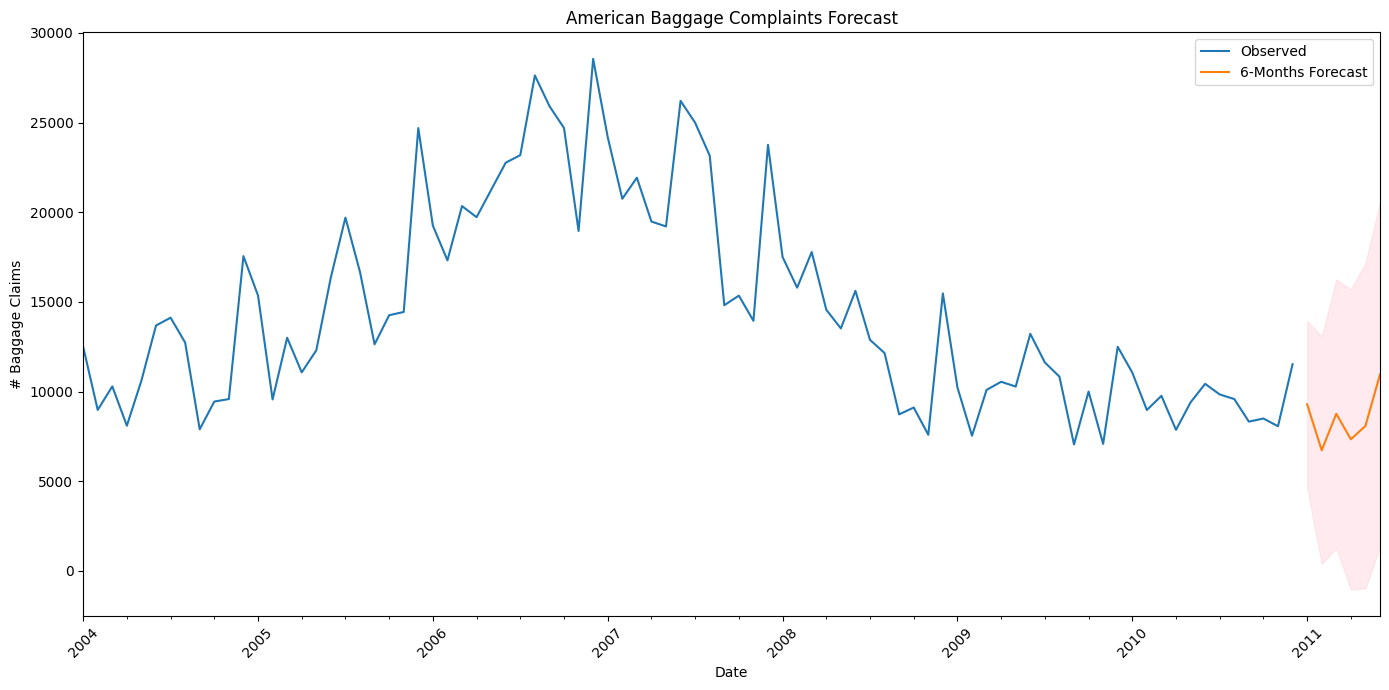

In [34]:

# Plot forecast
plt.figure(figsize=(14, 7))
american_baggage_ts.plot(label='Observed', legend=True)
mean_forecast2.plot(label='6-Months Forecast', legend=True)
plt.fill_between(confidence_intervals2.index,
                 confidence_intervals2.iloc[:, 0],
                 confidence_intervals2.iloc[:, 1], color='pink', alpha=0.3)
plt.title("American Baggage Complaints Forecast")
plt.xlabel("Date")
plt.ylabel("# Baggage Claims")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

In [37]:
## Convert notebook to HTML
%%shell
jupyter nbconvert '/content/drive/MyDrive/Colab Notebooks/6025 - Predictive Analytics/Forecasting Project/Forecasting_Project_Macon_Barker.ipynb' --to html

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/6025 - Predictive Analytics/Forecasting Project/Forecasting_Project_Macon_Barker.ipynb to html
[NbConvertApp] Writing 2548512 bytes to /content/drive/MyDrive/Colab Notebooks/6025 - Predictive Analytics/Forecasting Project/Forecasting_Project_Macon_Barker.html
